### MBTI Classification

Myers-Briggs-Type Indicator (MBTI) is a introspective self-report survey questionnaire that indicates the personality of different people percieving the world. There are 16 categories of MBTI as a combination of choosing one for each from the four pairs of preferences: extraversion/introversion, sensing/intuition, thinking/feeling, and judging/perception. As the MBTI test from 16-personalities website gained reputation, MBTI became a very popular tool in Korea to categorize and discuss about the people's personality in real life. Although there are criticisms on it's unscientific origin, MBTI is still widely used as a topic for conversation in Korean society. Because of that reason, I also got interested in this personality type indicator and wanted to investigate on how it works through machine learning. 

My goal for this project is to classify the Myers-Briggs-Type Indicator (MBTI) of the respondants from the data. The question in mind is about how to classify MBTI accurately and effectively. The data I'm using to achieve this task is from Kaggle, and it includes the various responses of participants on the questions they were asked from the 16-personalities test and the resulting MBTI. I aim to apply two different supervised classification model on the data and find a better model that results in higher accuracy after using cross-validation. 


Data Source: https://www.kaggle.com/datasets/anshulmehtakaggl/60k-responses-of-16-personalities-test-mbt




In [365]:
# import block
import random
import classification

# matplotlib for graphing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# numpy and pandas for wrangling data
import numpy as np
import pandas as pd

# sklearn for classification algorithms and cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data
from six import StringIO

In [277]:
# Read data as pandas
mbti = pd.read_csv("personality.csv", header=0, index_col = "Response Id",encoding='cp1252')

# Change data to numpy 
mbti_np = mbti.to_numpy()

# Shape of the data
print(mbti_np.shape)


(59999, 61)


Becase the size of the data is too big, I decided to cut the data to be the first 5000 rows of the full 59999 rows of data. This will decrease the computation time significantly, as well as do a better job in visualizing the algorithms. Notice that the rows are reasonably evenly divided for each classes.

In [278]:
# For the ease, I'm cutting the data to have 5000 rows of the full data 
# full data is too big to create a picture 

# cut the data
mbti_cut = mbti.iloc[:5000]

# visualize first 10 rows of the data
mbti_cut.head(10)


,You regularly make new friends.,You spend a lot of your free time exploring various random topics that pique your interest,Seeing other people cry can easily make you feel like you want to cry too,You often make a backup plan for a backup plan.,"You usually stay calm, even under a lot of pressure","At social events, you rarely try to introduce yourself to new people and mostly talk to the ones you already know",You prefer to completely finish one project before starting another.,You are very sentimental.,You like to use organizing tools like schedules and lists.,Even a small mistake can cause you to doubt your overall abilities and knowledge.,...,You believe that pondering abstract philosophical questions is a waste of time.,"You feel more drawn to places with busy, bustling atmospheres than quiet, intimate places.",You know at first glance how someone is feeling.,You often feel overwhelmed.,You complete things methodically without skipping over any steps.,You are very intrigued by things labeled as controversial.,You would pass along a good opportunity if you thought someone else needed it more.,You struggle with deadlines.,You feel confident that things will work out for you.,Personality
Response Id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,-1,0,0,0,0,0,ENFP
1,0,0,-2,-3,-1,2,-2,0,3,0,...,0,-2,0,2,0,-1,-1,-1,3,ISFP
2,0,0,2,0,-1,2,0,0,1,0,...,0,2,0,2,-1,0,1,2,1,INFJ
3,0,-1,3,-1,0,0,-2,0,-2,0,...,0,0,-1,-1,0,1,0,-2,-1,ISTP
4,0,0,-1,0,2,-1,-2,0,1,0,...,0,1,0,2,0,1,-1,2,-1,ENFJ
5,0,0,1,0,1,-2,-1,0,2,1,...,0,3,0,2,0,0,2,2,1,INTJ
6,0,0,-2,0,-1,1,-2,0,1,1,...,0,-2,1,2,0,0,-1,-1,1,ISFP
7,0,0,-3,0,-1,0,-2,0,0,0,...,0,-1,0,1,0,0,-1,2,-1,INTJ
8,0,0,-2,1,-2,1,-1,0,2,0,...,0,1,0,1,0,0,3,2,-2,ENTJ


In [236]:
# visualize how many rows are there for each classes

print(mbti_cut.groupby(by="Personality").size())

Personality
ENFJ    282
ENFP    308
ENTJ    335
ENTP    293
ESFJ    308
ESFP    325
ESTJ    353
ESTP    310
INFJ    312
INFP    307
INTJ    318
INTP    295
ISFJ    304
ISFP    352
ISTJ    301
ISTP    297
dtype: int64


In [279]:
# data preparation

# change the data into numpy array
mbti_cut = mbti_cut.to_numpy()


### Model 1 :  Decision Trees

#### A. Choosing Hyperparameters

I imediately thought about the decision tree algorithm for classifying MBTI because the act of taking survey sounded to be closely related to the idea of branching.

In [280]:
# First Model: Decision Trees using sklearn

# 1. Fit the data 

# a. Split the data into the input variables and the target classes
in_mbti_cut = mbti_cut[:,:-1]
out_mbti_cut = mbti_cut[:,-1]

# Get the variable names 
var_names = list(mbti.columns)[0:-1]

# b. Specify our model
tree = DecisionTreeClassifier()

# c. Fit the model to the data
tree.fit(in_mbti_cut, out_mbti_cut)

# d. Test the prediction on a response
print("Response and MBTI of the respondant with id 10: ", mbti_cut[10,:])
print("MBTI Prediction: ", tree.predict([mbti_cut[10,:-1]]))

# look at the accuracy
print("Accuracy: ", tree.score(in_mbti_cut, out_mbti_cut))

Response and MBTI of the respondant with id 10:  [0 0 -1 3 2 1 2 0 -1 0 3 1 0 1 1 -1 0 0 2 1 0 0 0 0 1 2 1 0 0 0 1 0 -3 0 3
 -3 -3 0 2 0 1 2 1 1 -2 0 -1 0 -3 0 0 0 2 0 0 0 0 3 0 0 'ENFP']
MBTI Prediction:  ['ENFP']
Accuracy:  1.0


I first applied a general decision tree model without any hyperparameters set to limit the tree. This will result in 100% accuracy since the model was fit to the full data and the tree will keep branching until there are 1 leaf left for each observation. This can result in the problem of overfitting, which makes the model not to function well when it is used to predict the new test set of the data. 

Therefore, we can prune the tree to control the size of the tree to make sure the model doesn't overfit. We can decide the alpha (hyperparameter) for cost-complexity pruning by looking at how different decision trees perform in the training and test set. The good model should result in high test accuracy with reasonably high train accuracy, so I'm aiming to find the ccp_alpha that results in higher accuracy on the test set. 


In [239]:
# Information about cost-complexity pruning found in:
#https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

# Split the data into test, train 
X_train, X_test, y_train, y_test = train_test_split(in_mbti_cut, out_mbti_cut, random_state=0)

# Get effective alphas
tree2 = DecisionTreeClassifier(random_state=0)
path = tree2.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

In [240]:
# Fit decision tree for all the effective alphas
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
    
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]


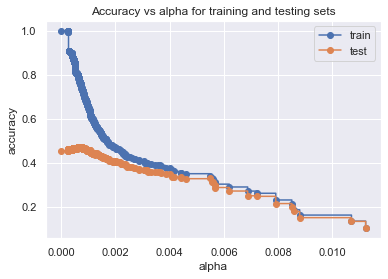

In [61]:
# Predict the train and test for each decision tree
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]

# Plot the graph to find the reasonable alpha
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

After plotting the graph of the prediction of the train and test data for different alpha values, it looks like the alpha = 0.001 is reasonably a good value because the test accuracy seems to be highest around there while the train accuracy is also relatively high. Therefore, I'm pruning the tree with ccp_alpha = 0.001.

In [281]:
# Specify our model
tree3 = DecisionTreeClassifier(ccp_alpha=0.001, random_state=0)

# Fit the model to the data
tree3.fit(in_mbti_cut, out_mbti_cut)

# d. Test the prediction on a response
print("Response and MBTI of the respondant with id 10: ", mbti_cut[10,:])
print("MBTI Prediction: ", tree3.predict([mbti_cut[10,:-1]]))

print("Accuracy: ", tree3.score(in_mbti_cut, out_mbti_cut))

Response and MBTI of the respondant with id 10:  [0 0 -1 3 2 1 2 0 -1 0 3 1 0 1 1 -1 0 0 2 1 0 0 0 0 1 2 1 0 0 0 1 0 -3 0 3
 -3 -3 0 2 0 1 2 1 1 -2 0 -1 0 -3 0 0 0 2 0 0 0 0 3 0 0 'ENFP']
MBTI Prediction:  ['ESFJ']
Accuracy:  0.5978


The accuracy on the training set is 0.60, which is reasonably high. This ccp_alpha=0.001 prevents the decision tree to overfit, while the train accuracy about 60% still suggests that it is also not very underfit. The visual representation of the decision tree model is shown below.

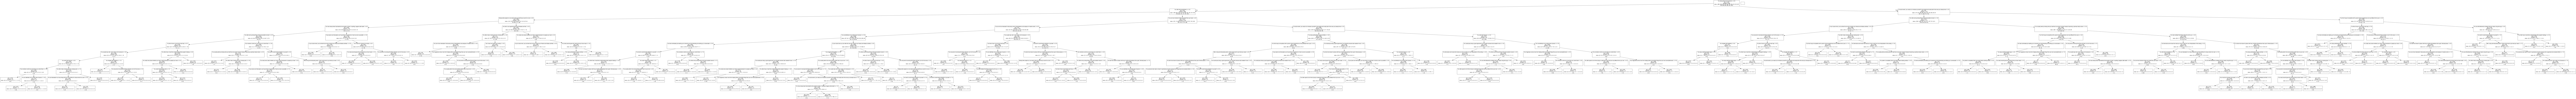

In [83]:
# visualize the pruned tree 
dot_data = StringIO()

export_graphviz(tree3, out_file=dot_data, feature_names=var_names)
(tree_vis, ) = graph_from_dot_data(dot_data.getvalue())

Image(tree_vis.create_png())

#### B. Cross-Validation

In order to assess the accuracy of the decision tree model, I will run a 5-fold cross-validation to compute the mean squared error for each train-test classification, and get the average MSE for the entire 5 rounds of classification.

In [290]:
# split the data into train/validation and test for CV
#random.shuffle(mbti_cut)

cv_data = mbti_cut[:4500]
test_data = mbti_cut[4500:]

In [368]:

# 5-fold CV of decision tree model
classification.k_fold_CV(cv_data, var_names, 5, "Decision Tree")



0.5484444444444444

The mean squared errors for 5-fold cross-validation on decision tree model turns out to be 0.548 on average. This means that the model is inaccurate for about 54.8%. This is quite a large number for an error rate to be, so it might not be great to use decision tree as a model.  

### Model 2 : Support Vector Machine

#### A. Choosing Hyperparameters

Next, I will be fitting the data into the Support Vector Machine. Although it is very hard to visualize the data using this model under the circumstance when the dimension is really high, it is worth trying because the support vector machine algorithm is very rigid and strong. It has the advantage of being flexible because it supports different kernels to project the data to cut through the dimensions. I will investigate three different SVM with different kernels.

In [370]:
# svm using rbf kernel with C=1
sv1 = svm.SVC(kernel='rbf',C=1)
sv1.fit(cv_data[:,:-1], cv_data[:,-1])
pred1 = sv1.predict(test_data[:,:-1])

# svm using polynomial kernel with C=1
sv2 = svm.SVC(kernel='poly', degree=3,gamma = 'auto',C=1)
sv2.fit(cv_data[:,:-1], cv_data[:,-1])
pred2 = sv2.predict(test_data[:,:-1])

# svm using linear kernel with C=1
sv3 = svm.SVC(kernel='linear',C=1)
sv3.fit(cv_data[:,:-1], cv_data[:,-1])
pred3 = sv3.predict(test_data[:,:-1])

# print the mse of SVM with different kernels predicting the test data (10% of the original)
print("MSE of SVM with rbf kernel:", classification.compute_mse(test_data[:,-1], pred1))
print("MSE of SVM with polynomial kernel:", classification.compute_mse(test_data[:,-1], pred2))
print("MSE of SVM with linear kernel:", classification.compute_mse(test_data[:,-1], pred3))

MSE of SVM with rbf kernel: 0.012
MSE of SVM with polynomial kernel: 0.01
MSE of SVM with linear kernel: 0.14


According to the computation, the SVM model with polynomial kernel of degree 3 and the regularization parameter C = 1 yields the smallest mse when classifying the MBTI of 10% of the original data after being fit to the 90% of the original data. However, it doesn't significantly matter to use any one of the SVM with three different hyperparameters since the differences of mse are 0.001~0.003, which is neglectable. Therefore, I will proceed with the SVM with polynomial kernel, although it doesn't really matter which one to choose.

#### B. Cross-Validation

In [369]:
# cross validation for SVM

classification.k_fold_CV(cv_data, var_names, 5, "SVM")


0.017333333333333333

Support Vector Machine model generally does better with the classification, with mean mse of 0.02 for 5-fold cross validation. This means that the model is accurate for about 98% of the validation, which is actually very accurate for the train/validation set. Comparing 5-fold cross-validation result of Decision Tree and SVM models, it is clearly shown that the SVM does much better job than Decision Tree Classifier. Therefore, I will proceed with using SVM as a model to classify MBTI.

I've already computed the mse to measure the performance of SVM with poly=3 and C=1 by fitting it to the all of the train/validation set used for cross validation and predicting the MBTI of the 10% test set. The mse was 0.01, which means an impressive accuracy of 99%. This numeric information indeed suggests that SVM can be the best model to classify this MBTI data. 

Since I cutted the data at the first place, I still have some left over data to test the model on. I can try predicting the MBTI of the 500 respondants from the unused data, after fitting it into the entired cutted data with 5000 respondants.

In [344]:
# get 500 new respondants from the unused data
new_test = mbti_np[5000:5500,:]

# our model
sv_final = svm.SVC(kernel='poly', degree=3, C=1)
# fit and predict
sv_final.fit(in_mbti_cut, out_mbti_cut)
prediction = sv_final.predict(new_test[:,:-1])

# MSE and Accuracy
print("MSE of SVM:", classification.compute_mse(new_test[:,-1], prediction))
print("Accuracy:", sv_final.score(new_test[:,:-1],new_test[:,-1]))



MSE of SVM: 0.026
Accuracy: 0.974


The accuracy is still very high with 97.4%. Therefore, I can confidently claim that SVM with poly=3, C=1 is a great model to classify the MBTI of different respondants.

## Report

### Introduction

Myers-Briggs-Type Indicator (MBTI) is a introspective self-report survey questionnaire that indicates the personality of different people percieving the world. There are 16 categories of MBTI as a combination of choosing one for each from the four pairs of preferences: extraversion/introversion, sensing/intuition, thinking/feeling, and judging/perception. As the MBTI test from 16-personalities website gained reputation, MBTI became a very popular tool in Korea to categorize and discuss about the people's personality in real life. Although there are criticisms on it's unscientific origin, MBTI is still widely used as a topic for conversation in Korean society. Because of that reason, I also got interested in this personality type indicator and wanted to investigate on how it works through machine learning.

My goal for this project is to classify the Myers-Briggs-Type Indicator (MBTI) of the respondants from the data. The question in mind is about how to classify MBTI accurately and effectively. The data I'm using to achieve this task is from Kaggle, and it includes the various responses of participants on the questions they were asked from the 16-personalities test and the resulting MBTI. I aim to apply two different supervised classification model on the data--Decision Tree and Support Vector Machine--and find a better model that results in higher accuracy after using cross-validation. Then, I will fit the model with to the entire data, and assess its performance again using the test data. 

### Approaches

While I was proceeding, I faced several challenges caused by the big size of the data, such as having long running time for both the algorithm and the visualizations. Especially in Decision Tree model, the branching got enormously huge, and the computer didn't seem to be able to handle all the computations. Therefore, I decided to cut the data to be in a size of (5000, 61) instead of using the full data with a size of (59999, 61). This decision allowed me to have left over data to test the model at the end. 

I first chose to fit a Decision Tree algorithm because the algorithm sounded most intuitive to me to classify the personality. I could visualize how the MBTI test might also have similar branching algorithm like the decision tree. Having that in mind, I was expecting decision tree to yield a higher accuracy when fit to the data. I also chose the hyperparameters that make sure the model doesn't overfit nor underfit, which ended up to be a cost-complexity pruning alpha value of 0.001. However, the 5-fold cross-validation result of this decision tree model wasn't so great, because the mean squared errors was 0.548 on average. This meant that the model was inaccurate for about 54.8%, which suggests that the model can't even classify half of the new responses to a correct MBTI.

Then, I turned to the Support Vector Machine. I couldn't really intuitively understand how the support vector machine can work in a high-dimensional data like the MBTI dataset that has 60 different variables. However, as I though more about it, using the kernel function to cut through the dimensions sounded like it a decent model to try out. I chose to use the SVM model with polynomial kernel of degree 3 and the regularization parameter C = 1  after comparing the mse, and ran cross-validation with it. The result was that the SVM model outperformed Decision Tree model, with mean mse of 0.02 for 5-fold cross validation. This model was accurate for about 98% of the validation. When I fitted this model again to the whole data to predict the classification of new test data from the original data, the accuracy was still very high with 97.4%. 


### Conclusion

It was surprising for me to see SVM doing better job than Decision Tree, because it contradicted with my initial guess. However, it made sense if we consider the algorithm of the way the MBTI test categorizes personality as something other than the branching mechanism of decision tree. Since the test accuracy was very high, there must have been some kind of formula in categorizing the personality using different weights for the responses on each questions that puts each responses into clear categories. In this case, the responses were probably clearly separated for each classes, positioned in distinct places when visualized in 60-dimensions. There must have been no respondants making ambiguous moves, like checking 0 (neither disagree nor agree) for all the questions. 

I learned that the Decision Tree algorithm is a lot more restricted in the context of the data to achieve a high performance. When we are not sure about whether one variable is weighted a lot higher than the others, performing decision tree may be able to give some insights on that. If the decision tree doesn't do great, then the data probably doesn't have a strong context or relationships between the variables and the class. I also learned that although the SVM is harder to visualize in high dimensions, the performance can be high if the data are clearly separated. In addition, it will be nice to search about how the MBTI test actually gets scored, and compare the scoring mechanism and the classification algorithm.




https://datascience.stackexchange.com/questions/103576/why-svm-works-well-with-high-dimensional-data
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


### Value Add Statement

1) I consulted with Lab 14,15-SVM, and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html to recall my memory on SVM and how to implement it using sklearn.

2) I consulted with Lab 16,17-Decision Tree: to recall my memory on Decision Tree and how to implement it using sklearn.

3) I consulted with https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html to decide how to prune the tree. I used the code to plot the alpha vs test/train accuracy graph, but I decided the alpha and wrote the code to fit the model and compute mse.

4) I consulted with Homework 5-K-fold Cross Validation: to see the format of the k-fold function and compute_mse function I built by myself. I modified it to be applicable to classification setting.

5) All the other parts including data preparation and manipulation are done by me. 